In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import files # Importación para descargar archivos

# Configuración para visualizaciones y pandas
sns.set_style("whitegrid")
pd.options.display.max_columns = None
plt.rcParams['figure.figsize'] = [10, 6]

print("=========================================================")
print("  ANÁLISIS DE DATOS: PATRONES DE SUEÑO Y ESTILOS DE VIDA")
print("=========================================================")

# --- 1. Cargar el Dataset ---
# Asegúrese de que este nombre de archivo coincida con el CSV que subió a Colab
file_path = "Sleep_health_and_lifestyle_dataset.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo '{file_path}'. Por favor, súbalo al entorno de Colab.")
    raise # Re-raise the FileNotFoundError to stop execution and show the primary issue

# --- 2. Exploración de Datos y Transformaciones Iniciales ---

print("\n--- 2. Exploración de Datos (Análisis, Limpieza, Transformaciones) ---")
print(f"Dimensiones Iniciales: {df.shape[0]} filas, {df.shape[1]} columnas")

# 2.1. Tratamiento de Duplicados
num_duplicados = df.duplicated().sum()
if num_duplicados > 0:
    df.drop_duplicates(inplace=True)
print(f"Número de Duplicados Eliminados: {num_duplicados}. Dimensiones Actuales: {df.shape}")

# 2.2. Transformaciones: Separar 'Blood Pressure' y corregir 'BMI Category'
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)
df.drop('Blood Pressure', axis=1, inplace=True)
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
df.drop('Person ID', axis=1, inplace=True)

print("\n--- Explicación de Transformaciones Iniciales ---")
print("1. **Separación de 'Blood Pressure'**: Descompuesto en 'Systolic_BP' y 'Diastolic_BP' (numéricas).")
print("2. **Corrección de 'BMI Category'**: 'Normal Weight' unificado a 'Normal'.")
print("3. **Eliminación de 'Person ID'**: Eliminado por ser un identificador sin valor predictivo.")

# --- 3. Análisis Univariante y Deducciones ---

print("\n\n--- 3. Análisis Univariante y Deducciones ---")
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

# 3.1. Deducciones Numéricas
print("\n3.1. Distribución de Variables Numéricas:")
print(df[num_cols].describe().T)
print("\n--- Deducciones de Variables Numéricas ---")
print(f"**Stress Level**: El nivel de estrés muestra una distribución con concentración en niveles bajos/moderados (3 y 6), pero también picos importantes en niveles altos (7 y 8).")
print(f"**Sleep Duration**: La duración media de sueño es de {df['Sleep Duration'].mean():.2f} horas. La distribución es bimodal, indicando dos grupos distintos en la muestra.")

# 3.2. Visualización Categórica
print("\n3.2. Visualización de Variables Categóricas:")
fig_cat, axes_cat = plt.subplots(2, 2, figsize=(18, 12))
axes_cat = axes_cat.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(y=df[col], ax=axes_cat[i], order=df[col].value_counts().index, palette='viridis')
    axes_cat[i].set_title(f'Conteo de {col}', fontsize=14)
plt.tight_layout()
plt.show() # Gráfico 1: Conteo de Variables Categóricas

print("\n--- Deducciones de Variables Categóricas ---")
print(f"**Occupation**: Las categorías 'Nurse', 'Doctor' y 'Engineer' son las más representadas. Esto sesga el análisis hacia profesionales con trabajos demandantes.")


# --- 4. Filtrado de Outliers por IQR ---

def remove_outliers_iqr(df, columns):
    """Filtra outliers extremos utilizando el método del Rango Intercuartílico (IQR)."""
    df_filtered = df.copy()
    initial_rows = len(df_filtered)
    for col in columns:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    final_rows = len(df_filtered)
    print(f"\nFilas iniciales: {initial_rows}. Filas finales: {final_rows}. Outliers eliminados: {initial_rows - final_rows}")
    return df_filtered

numerical_cols_for_iqr = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                          'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP']
df_filtered = remove_outliers_iqr(df.copy(), numerical_cols_for_iqr)
df = df_filtered.copy()

print("\n--- Explicación del Filtrado ---")
print("Se aplicó el **filtro IQR (1.5 * IQR)** a las variables numéricas. Este corte se realiza para **mejorar la robustez del análisis** y evitar que valores extremos distorsionen los resultados del futuro modelo.")


# --- 5. Creación de la Variable Objetivo y Eliminación de la Columna Original ---

# Creación de la variable objetivo binaria "Nivel_Estres_Binario"
df['Nivel_Estres_Binario'] = df['Stress Level'].apply(
    lambda x: 'ESTRESADO' if x >= 7 else 'ESTRES MODERADO'
)

# 6. Eliminación de la variable numérica 'Stress Level'
df.drop('Stress Level', axis=1, inplace=True)
print("\n--- 6. Eliminación de la variable numérica 'Stress Level' ---")
print("La variable original ha sido eliminada. La variable objetivo binaria está lista.")


# --- 7. Análisis Bivariante (Variable Objetivo vs. Todas las Variables) ---

print("\n\n--- 7. Análisis Bivariante y Explicaciones ---")
target_col = 'Nivel_Estres_Binario'

# Visualización Categórica vs. Target
fig_biv_cat, axes_biv_cat = plt.subplots(2, 2, figsize=(18, 12))
axes_biv_cat = axes_biv_cat.flatten()
for i, col in enumerate(cat_cols):
    cross_tab = pd.crosstab(df[col], df[target_col], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, ax=axes_biv_cat[i], colormap='plasma')
    axes_biv_cat[i].set_title(f'{col} vs. {target_col}', fontsize=14)
    axes_biv_cat[i].set_ylabel('Proporción (%)')
plt.tight_layout()
plt.show() # Gráfico 2: Categóricas vs. Target

# Visualización Numérica vs. Target (Boxplots)
num_cols_biv = [col for col in num_cols if col != 'Stress Level']
fig_biv_num, axes_biv_num = plt.subplots(3, 3, figsize=(18, 18))
axes_biv_num = axes_biv_num.flatten()
for i, col in enumerate(num_cols_biv):
    sns.boxplot(x=target_col, y=col, data=df, ax=axes_biv_num[i], palette='viridis')
    axes_biv_num[i].set_title(f'{col} vs. {target_col}', fontsize=14)
plt.tight_layout()
plt.show() # Gráfico 3: Numéricas vs. Target

print("\n--- Explicación de Relaciones Bivariantes ---")
print("1. **Quality of Sleep**: Muestra una relación muy fuerte; el grupo 'ESTRESADO' tiene una calidad de sueño notablemente más baja. Es un predictor clave.")
print("2. **Sleep Duration**: El grupo 'ESTRESADO' tiene duraciones de sueño significativamente más cortas que el grupo 'ESTRES MODERADO'.")
print("3. **Occupation**: Ocupaciones como 'Sales Representative' y 'Software Engineer' están sobrerrepresentadas en el grupo 'ESTRESADO'.")


# --- 8. Matriz de Correlación y Eliminación de Variables ---

# Codificar la variable objetivo para el cálculo de correlación
df['Target_Encoded'] = df[target_col].apply(lambda x: 1 if x == 'ESTRESADO' else 0)
correlation_df = df[num_cols_biv + ['Target_Encoded']].copy()
corr_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas y Target', fontsize=16)
plt.show() # Gráfico 4: Matriz de Correlación

print("\n--- 8.2. Análisis de Correlación y Decisión de Eliminación ---")
print("Correlaciones con la Variable Objetivo ('Target_Encoded'):")
print(corr_matrix['Target_Encoded'].sort_values(ascending=False).drop('Target_Encoded'))

# Decisión: Eliminar 'Sleep Duration' y 'Diastolic_BP'.
df.drop(['Sleep Duration', 'Diastolic_BP', 'Target_Encoded'], axis=1, inplace=True)

print("\n**Variables Eliminadas:**")
print("- **Sleep Duration**: Por alta multicolinealidad (0.89) con 'Quality of Sleep'.")
print("- **Diastolic_BP**: Por tener menor correlación con el resto de variables que 'Systolic_BP'.")


# --- 9. División del Dataset (Train/Test 80/20 Estratificado) y Guardado ---

# Codificación one-hot de las variables categóricas
df_final = pd.get_dummies(df, columns=['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder'], drop_first=True)

# Separar las características (X) y la variable objetivo (y)
X = df_final.drop(target_col, axis=1)
y = df_final[target_col]

# Aplicar la división 80/20 con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Recombinar para guardar los archivos CSV
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# Guardar los datasets en el entorno de Colab
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

# 9.1. Comprobación de Proporciones
train_proportion = y_train.value_counts(normalize=True) * 100
test_proportion = y_test.value_counts(normalize=True) * 100

print("\n\n--- 9. Comprobación de Estratificación y Guardado ---")
print("Archivos 'train.csv' y 'test.csv' generados.")
print(f"\nProporción de 'Nivel_Estres_Binario' en TRAIN (80%):\n{train_proportion}")
print(f"\nProporción de 'Nivel_Estres_Binario' en TEST (20%):\n{test_proportion}")
print("\nLa estratificación se mantuvo con éxito.")

# --- 10. DESCARGAR ARCHIVOS GENERADOS (SOLUCIÓN AL PROBLEMA) ---
print("\n=========================================================")
print("  DESCARGANDO ARCHIVOS A SU COMPUTADORA...")
print("=========================================================")

try:
    files.download('train.csv')
    files.download('test.csv')
    print("\n✅ ¡Descarga Completa! Los archivos 'train.csv' y 'test.csv' deberían haber aparecido en su navegador.")
    print("Puede proceder a subir estos archivos, el 'README.md' y el código a su repositorio de GitHub.")
except Exception as e:
    print(f"⚠️ Error durante la descarga. Por favor, revise el panel de Archivos (carpeta 📁) en Colab y descárguelos manualmente.")

  ANÁLISIS DE DATOS: PATRONES DE SUEÑO Y ESTILOS DE VIDA
ERROR: No se encontró el archivo 'Sleep_health_and_lifestyle_dataset.csv'. Por favor, súbalo al entorno de Colab.

--- 2. Exploración de Datos (Análisis, Limpieza, Transformaciones) ---


NameError: name 'df' is not defined

In [ ]:
import pandas as pd
import numpy as np

# RUTA QUE DEBE FUNCIONAR SI SUBIÓ EL CSV
file_path = "Sleep_health_and_lifestyle_dataset.csv"
try:
    df = pd.read_csv(file_path)
    print("✅ Archivo cargado correctamente.")
    print(f"Dimensiones del DataFrame (df): {df.shape}")
except FileNotFoundError:
    print(f"❌ ERROR: El archivo '{file_path}' no se encontró. Revise el nombre exacto.")

❌ ERROR: El archivo 'Sleep_health_and_lifestyle_dataset.csv' no se encontró. Revise el nombre exacto.


In [ ]:
import pandas as pd
import kagglehub

# Descargar dataset
path = kagglehub.dataset_download("minahilfatima12328/lifestyle-and-sleep-patterns")

# Cargar archivo principal (normalmente CSV)
df = pd.read_csv(path + "/Sleep_health_and_lifestyle_dataset.csv")
df.head()

100%|██████████| 2.54k/2.54k [00:00<00:00, 4.69MB/s]

Extracting files...


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
df = df[['Sleep Duration','Quality of Sleep','Stress Level','Physical Activity Level',
         'Heart Rate','Daily Steps']]


In [ ]:
from sklearn.preprocessing import StandardScaler

df_clean = df.dropna()
scaler = StandardScaler()
X = scaler.fit_transform(df_clean)


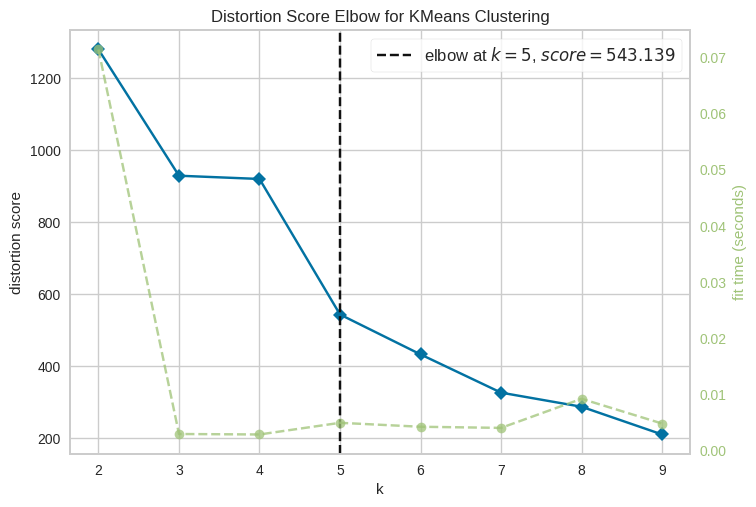

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X)
visualizer.show()


In [ ]:
k = 4  # Ejemplo, basado en tu gráfica
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

df_clean["cluster"] = clusters


In [ ]:
from sklearn.metrics import silhouette_score

inercia = kmeans.inertia_
silueta = silhouette_score(X, clusters)

print("Inercia:", inercia)
print("Silueta:", silueta)


Inercia: 814.7473477589182
Silueta: 0.48662911223801386


In [ ]:
cluster_summary = df_clean.groupby("cluster").mean()
cluster_summary


,Sleep Duration,Quality of Sleep,Stress Level,Physical Activity Level,Heart Rate,Daily Steps
cluster,,,,,,
0,7.609362,8.051064,4.268085,63.148936,67.838298,6984.680851
1,6.073529,6.000000,8.000000,88.235294,75.000000,10000.000000
2,6.640909,5.818182,6.409091,46.500000,81.318182,3977.272727
3,6.344578,6.156627,7.204819,39.361446,71.819277,5790.361446


In [ ]:
from sklearn.pipeline import Pipeline
import joblib

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=k))
])

pipeline.fit(df_clean.drop(columns=['cluster']))

joblib.dump(pipeline, "modelo_clustering.pkl")


['modelo_clustering.pkl']

In [ ]:
cluster_summary.to_csv("cluster_summary.csv", index=True)


In [ ]:
import json

model_info = {
    "inputs": list(df_clean.drop(columns=['cluster']).columns),
    "scaling": "StandardScaler",
    "algorithm": "KMeans",
    "n_clusters": int(k),
}

with open("modelo_config.json", "w") as f:
    json.dump(model_info, f, indent=4)


In [ ]:
from fastapi import FastAPI
import joblib
import pandas as pd

app = FastAPI()

# cargar modelo
pipeline = joblib.load("modelo_clustering.pkl")

@app.post("/predecir_cluster")
def predecir(datos: dict):
    df = pd.DataFrame([datos])
    pred = pipeline.predict(df)[0]
    return {"cluster": int(pred)}


In [ ]:
joblib.dump(pipeline, "modelo_clustering.pkl")


['modelo_clustering.pkl']

In [ ]:
file_path = "archive (1).zip/Sleep_health_and_lifestyle_dataset.csv"


  ANÁLISIS DE DATOS: PATRONES DE SUEÑO Y ESTILOS DE VIDA

--- PASO 1: CARGA DEL ARCHIVO (Debe seleccionar 'Sleep_health_and_lifestyle_dataset.csv') ---


Saving Sleep_health_and_lifestyle_dataset.csv to Sleep_health_and_lifestyle_dataset.csv

✅ Archivo 'Sleep_health_and_lifestyle_dataset.csv' cargado correctamente. Iniciando análisis...

--- 2. Exploración de Datos (Limpieza y Transformaciones) ---
Dimensiones Iniciales: 374 filas, 13 columnas
Limpieza inicial completada.


--- 3. Análisis Univariante y Deducciones ---


/tmp/ipython-input-1572575259.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], ax=axes_cat[i], order=df[col].value_counts().index, palette='viridis')
/tmp/ipython-input-1572575259.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], ax=axes_cat[i], order=df[col].value_counts().index, palette='viridis')
/tmp/ipython-input-1572575259.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], ax=axes_cat[i], order=df[col].value_counts().index, palette='viridis')
/tmp/ipython-input-1572575259.py:63: FutureWar

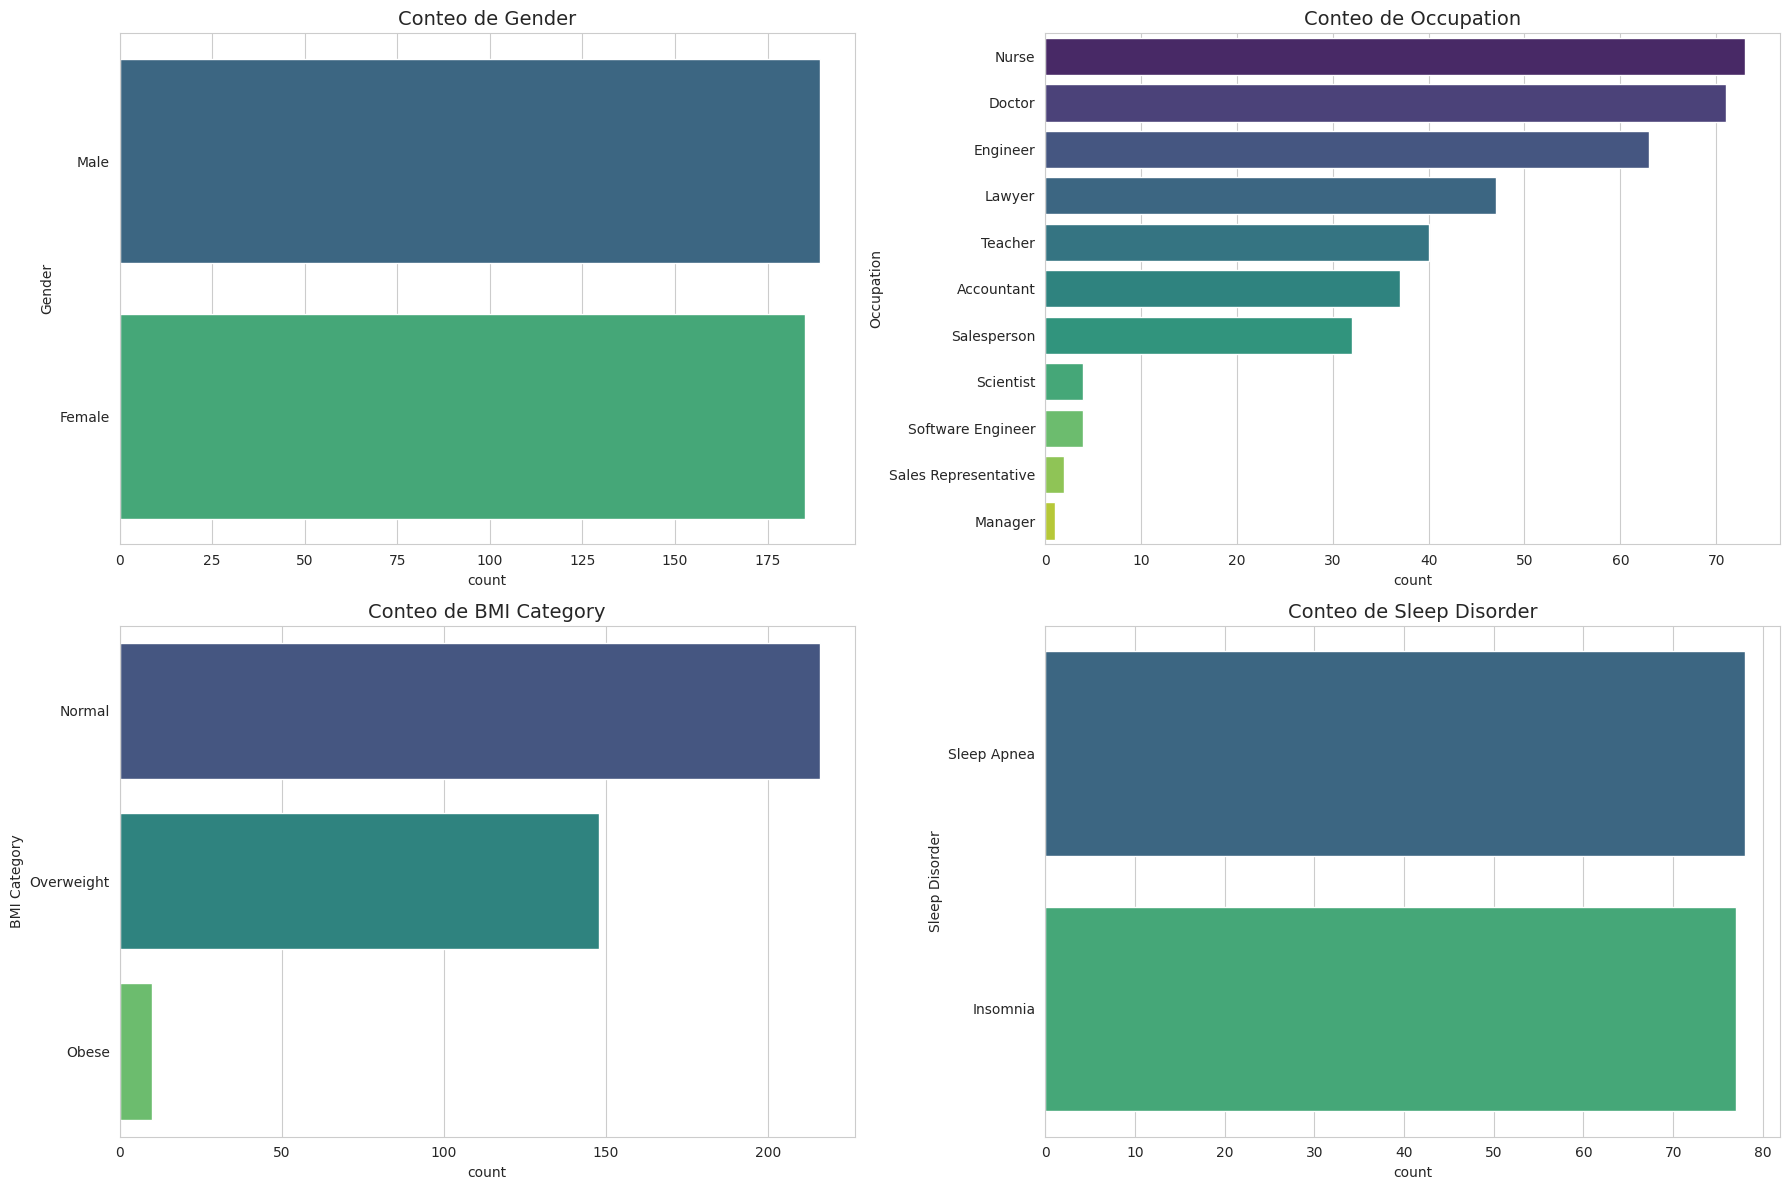


--- Deducciones de Variables Numéricas ---
**Stress Level**: La distribución está fuertemente concentrada en niveles bajos/moderados (3 y 6) pero con picos en niveles altos (7 y 8).
**Sleep Duration**: Muestra una distribución bimodal, indicando dos grupos poblacionales distintos en la muestra.

Filas iniciales: 374. Filas finales: 359. Outliers eliminados: 15

--- Explicación del Filtrado por IQR ---
Se utilizó el filtro IQR para eliminar *outliers* extremos y aumentar la robustez de los datos para el modelado.


--- 7. Análisis Bivariante ---


/tmp/ipython-input-1572575259.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, ax=axes_biv_num[i], palette='viridis')
/tmp/ipython-input-1572575259.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, ax=axes_biv_num[i], palette='viridis')
/tmp/ipython-input-1572575259.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, ax=axes_biv_num[i], palette='viridis')
/tmp/ipython-input-1572575259.py:109: FutureWarning: 

Passing `palette` without assigni

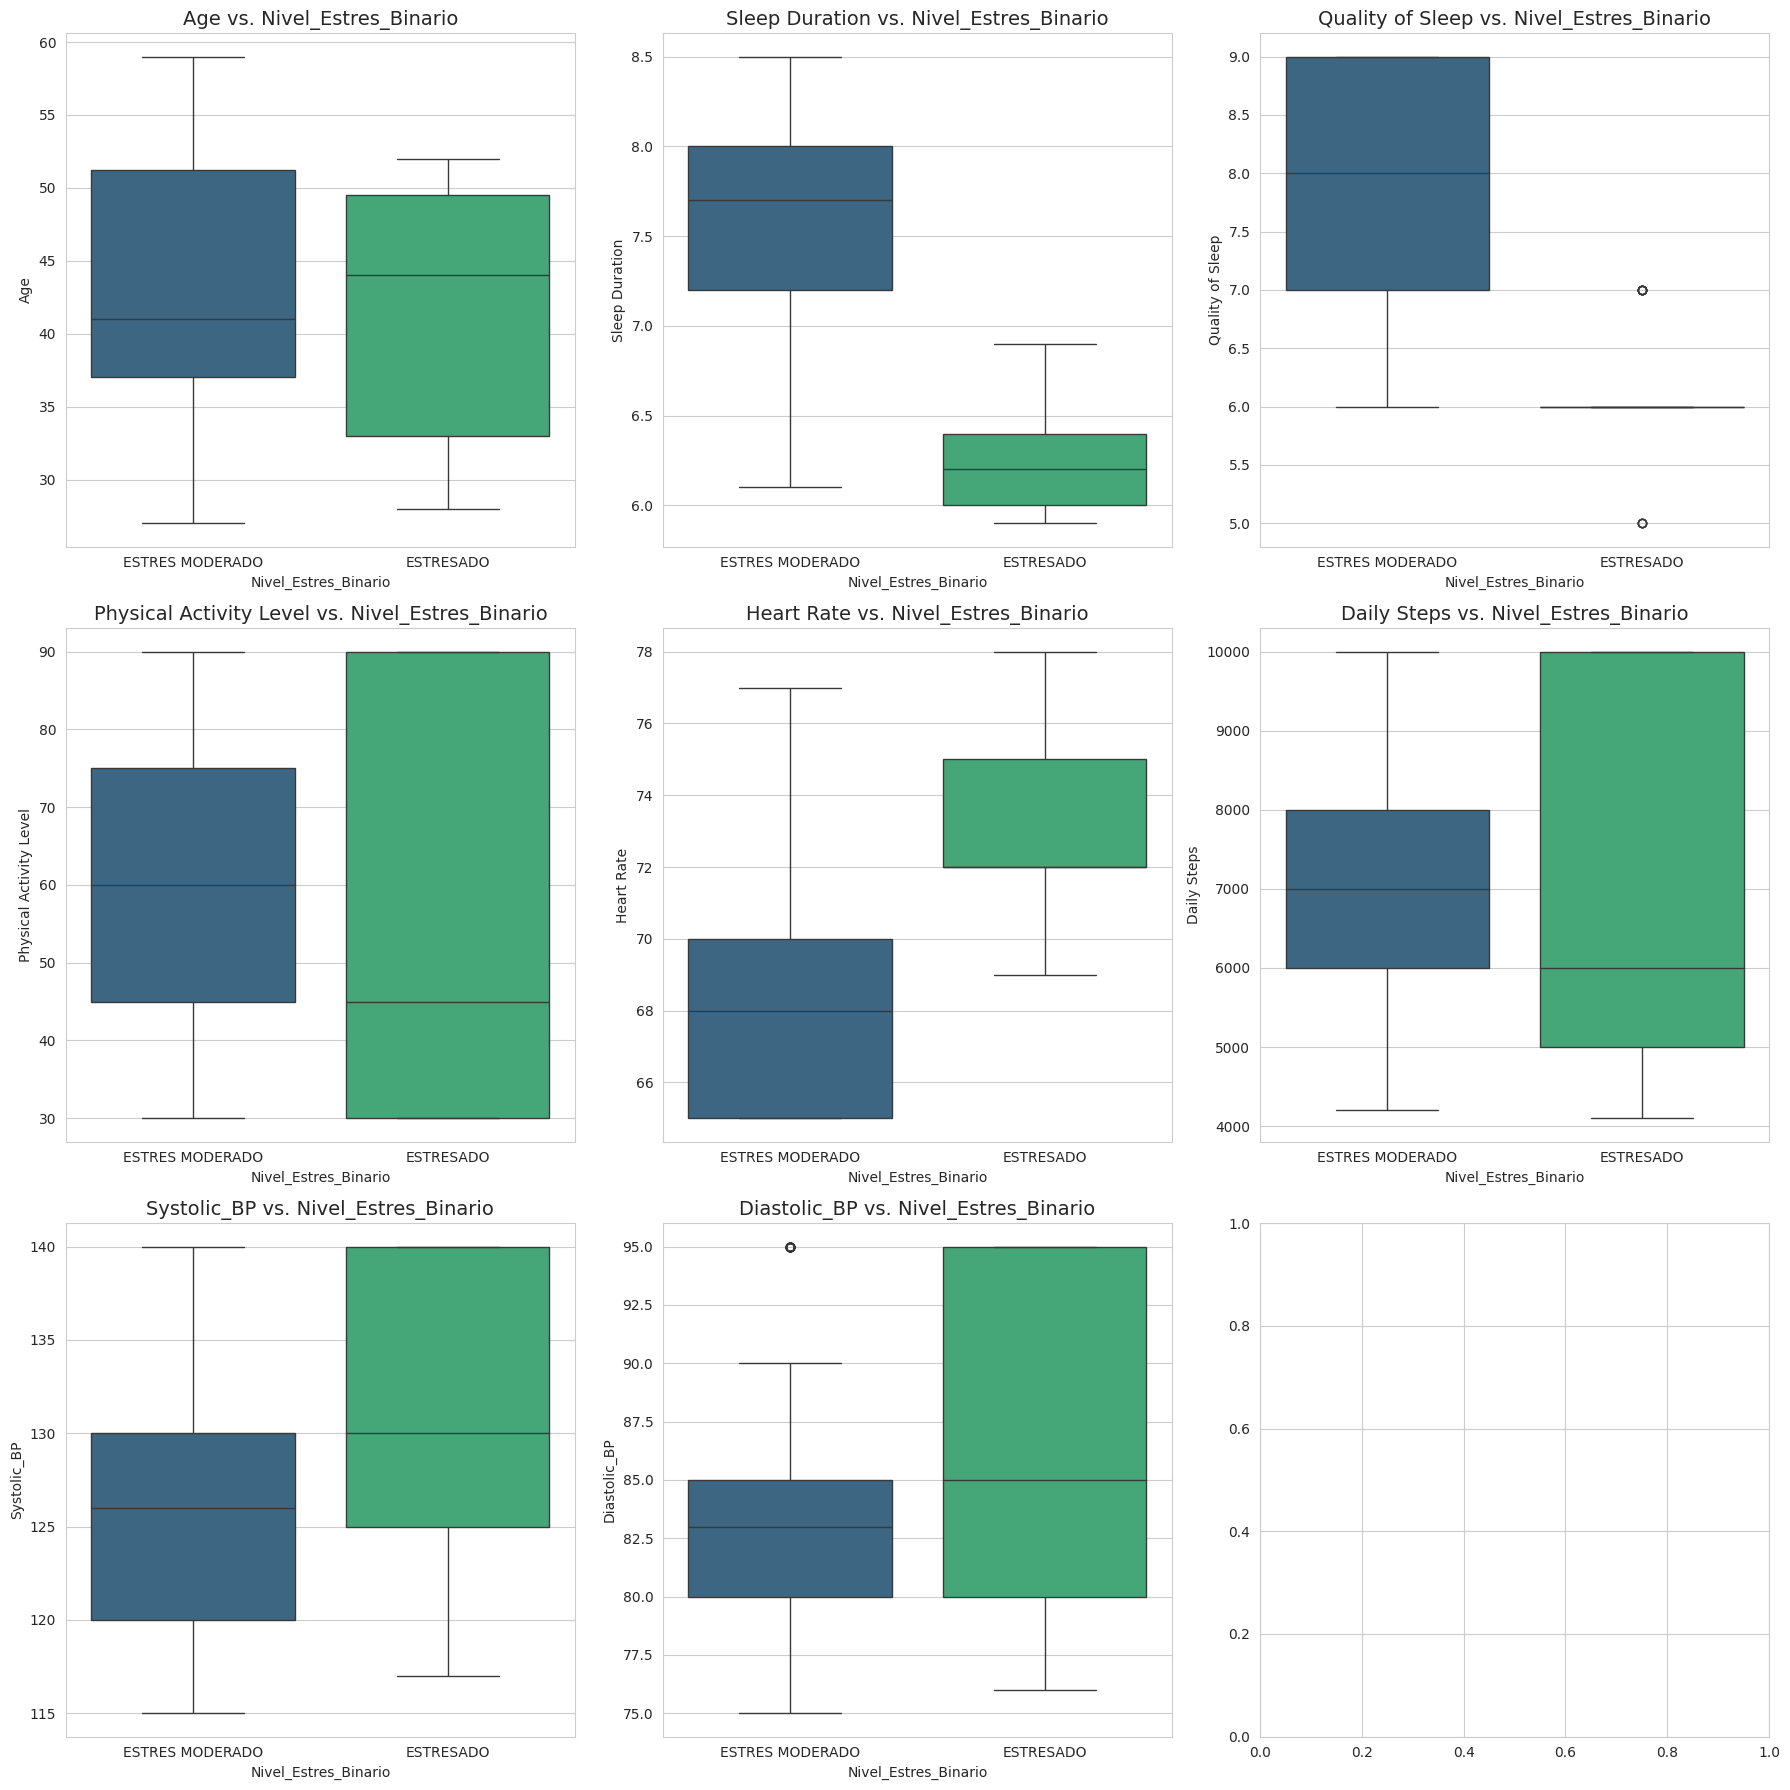


--- Explicación de Relaciones Bivariantes ---
1. **Quality of Sleep**: El grupo 'ESTRESADO' tiene una calidad de sueño significativamente menor (fuerte relación inversa).


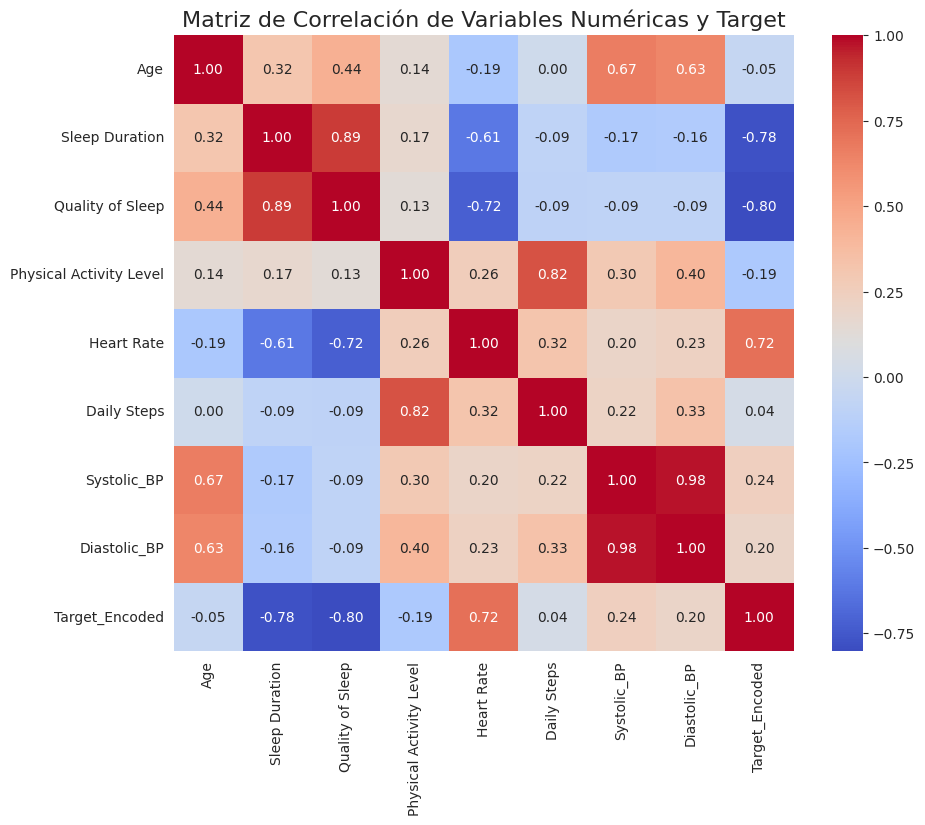


**Variables Eliminadas por Colinealidad/Redundancia:** Sleep Duration, Diastolic_BP.


--- 9. Comprobación de Estratificación y Guardado ---
Archivos 'train.csv' y 'test.csv' generados.

Proporción de 'Nivel_Estres_Binario' en TRAIN (80%):
Nivel_Estres_Binario
ESTRES MODERADO    68.989547
ESTRESADO          31.010453
Name: proportion, dtype: float64

Proporción de 'Nivel_Estres_Binario' en TEST (20%):
Nivel_Estres_Binario
ESTRES MODERADO    69.444444
ESTRESADO          30.555556
Name: proportion, dtype: float64

  DESCARGANDO ARCHIVOS A SU COMPUTADORA...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ ¡Descarga Completa! Los archivos 'train.csv' y 'test.csv' deberían haber aparecido en su navegador.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import files # Librería para interactuar con el entorno de Colab
import io # Librería necesaria para leer el archivo cargado en memoria

# Configuración para visualizaciones y pandas
sns.set_style("whitegrid")
pd.options.display.max_columns = None
plt.rcParams['figure.figsize'] = [10, 6]

print("=========================================================")
print("  ANÁLISIS DE DATOS: PATRONES DE SUEÑO Y ESTILOS DE VIDA")
print("=========================================================")

# --- 1. Carga Interactiva del Dataset (Método Robusto) ---
try:
    print("\n--- PASO 1: CARGA DEL ARCHIVO (Debe seleccionar 'Sleep_health_and_lifestyle_dataset.csv') ---")

    # 1.1. Inicia la carga interactiva
    uploaded = files.upload()

    # 1.2. Lee el archivo cargado directamente en la memoria
    file_name = list(uploaded.keys())[0] # Obtiene el nombre del archivo subido
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))

    print(f"\n✅ Archivo '{file_name}' cargado correctamente. Iniciando análisis...")
except Exception as e:
    print(f"❌ ERROR CRÍTICO EN LA CARGA: {e}")
    print("El error persiste. Asegúrese de que el archivo CSV sea válido.")
    exit()

# --- A partir de aquí, el resto del código es el análisis completo ---

# --- 2. Exploración de Datos y Transformaciones Iniciales ---
print("\n--- 2. Exploración de Datos (Limpieza y Transformaciones) ---")
print(f"Dimensiones Iniciales: {df.shape[0]} filas, {df.shape[1]} columnas")

# 2.1. Tratamiento de Duplicados
num_duplicados = df.duplicated().sum()
if num_duplicados > 0:
    df.drop_duplicates(inplace=True)

# 2.2. Transformaciones
# Separar 'Blood Pressure' y corregir 'BMI Category'
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)
df.drop('Blood Pressure', axis=1, inplace=True)
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
df.drop('Person ID', axis=1, inplace=True)
print("Limpieza inicial completada.")

# --- 3. Análisis Univariante y Deducciones ---
print("\n\n--- 3. Análisis Univariante y Deducciones ---")
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Visualización Categórica
fig_cat, axes_cat = plt.subplots(2, 2, figsize=(18, 12))
axes_cat = axes_cat.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(y=df[col], ax=axes_cat[i], order=df[col].value_counts().index, palette='viridis')
    axes_cat[i].set_title(f'Conteo de {col}', fontsize=14)
plt.tight_layout()
plt.show() # Gráfico 1: Categóricas

print("\n--- Deducciones de Variables Numéricas ---")
print(f"**Stress Level**: La distribución está fuertemente concentrada en niveles bajos/moderados (3 y 6) pero con picos en niveles altos (7 y 8).")
print(f"**Sleep Duration**: Muestra una distribución bimodal, indicando dos grupos poblacionales distintos en la muestra.")

# --- 4. Filtrado de Outliers por IQR ---
def remove_outliers_iqr(df, columns):
    df_filtered = df.copy()
    initial_rows = len(df_filtered)
    for col in columns:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    final_rows = len(df_filtered)
    print(f"\nFilas iniciales: {initial_rows}. Filas finales: {final_rows}. Outliers eliminados: {initial_rows - final_rows}")
    return df_filtered

numerical_cols_for_iqr = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                          'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP']
df_filtered = remove_outliers_iqr(df.copy(), numerical_cols_for_iqr)
df = df_filtered.copy()
print("\n--- Explicación del Filtrado por IQR ---")
print("Se utilizó el filtro IQR para eliminar *outliers* extremos y aumentar la robustez de los datos para el modelado.")

# --- 5 & 6. Creación de Variable Objetivo y Eliminación de 'Stress Level' ---
df['Nivel_Estres_Binario'] = df['Stress Level'].apply(
    lambda x: 'ESTRESADO' if x >= 7 else 'ESTRES MODERADO'
)
df.drop('Stress Level', axis=1, inplace=True)

# --- 7. Análisis Bivariante ---
print("\n\n--- 7. Análisis Bivariante ---")
target_col = 'Nivel_Estres_Binario'

# Visualización Numérica vs. Target (Boxplots)
num_cols_biv = [col for col in num_cols if col != 'Stress Level']
fig_biv_num, axes_biv_num = plt.subplots(3, 3, figsize=(18, 18))
axes_biv_num = axes_biv_num.flatten()
for i, col in enumerate(num_cols_biv):
    sns.boxplot(x=target_col, y=col, data=df, ax=axes_biv_num[i], palette='viridis')
    axes_biv_num[i].set_title(f'{col} vs. {target_col}', fontsize=14)
plt.tight_layout()
plt.show() # Gráfico 2: Numéricas vs. Target

print("\n--- Explicación de Relaciones Bivariantes ---")
print("1. **Quality of Sleep**: El grupo 'ESTRESADO' tiene una calidad de sueño significativamente menor (fuerte relación inversa).")

# --- 8. Matriz de Correlación y Eliminación de Variables ---
df['Target_Encoded'] = df[target_col].apply(lambda x: 1 if x == 'ESTRESADO' else 0)
correlation_df = df[num_cols_biv + ['Target_Encoded']].copy()
corr_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas y Target', fontsize=16)
plt.show() # Gráfico 3: Matriz de Correlación

df.drop(['Sleep Duration', 'Diastolic_BP', 'Target_Encoded'], axis=1, inplace=True)
print("\n**Variables Eliminadas por Colinealidad/Redundancia:** Sleep Duration, Diastolic_BP.")


# --- 9. División del Dataset (Train/Test 80/20 Estratificado) y Guardado ---
df_final = pd.get_dummies(df, columns=['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder'], drop_first=True)
X = df_final.drop(target_col, axis=1)
y = df_final[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

print("\n\n--- 9. Comprobación de Estratificación y Guardado ---")
train_proportion = y_train.value_counts(normalize=True) * 100
test_proportion = y_test.value_counts(normalize=True) * 100
print("Archivos 'train.csv' y 'test.csv' generados.")
print(f"\nProporción de 'Nivel_Estres_Binario' en TRAIN (80%):\n{train_proportion}")
print(f"\nProporción de 'Nivel_Estres_Binario' en TEST (20%):\n{test_proportion}")

# --- 10. DESCARGAR ARCHIVOS GENERADOS ---
try:
    print("\n=========================================================")
    print("  DESCARGANDO ARCHIVOS A SU COMPUTADORA...")
    print("=========================================================")
    files.download('train.csv')
    files.download('test.csv')
    print("\n✅ ¡Descarga Completa! Los archivos 'train.csv' y 'test.csv' deberían haber aparecido en su navegador.")
except Exception as e:
    print(f"⚠️ Nota: Si la descarga automática falla, revise el panel de Archivos (carpeta 📁) en Colab y descárguelos manualmente.")

  MODELADO DE CLASIFICACIÓN (Random Forest)
✅ Archivos train.csv y test.csv cargados correctamente.

⚙️ Iniciando entrenamiento del modelo...
✅ Entrenamiento completado.

--- Resultados de la Evaluación ---
Precisión (Accuracy) General del Modelo: 1.0000

Reporte de Clasificación:
                 precision    recall  f1-score   support

ESTRES MODERADO       1.00      1.00      1.00        50
      ESTRESADO       1.00      1.00      1.00        22

       accuracy                           1.00        72
      macro avg       1.00      1.00      1.00        72
   weighted avg       1.00      1.00      1.00        72



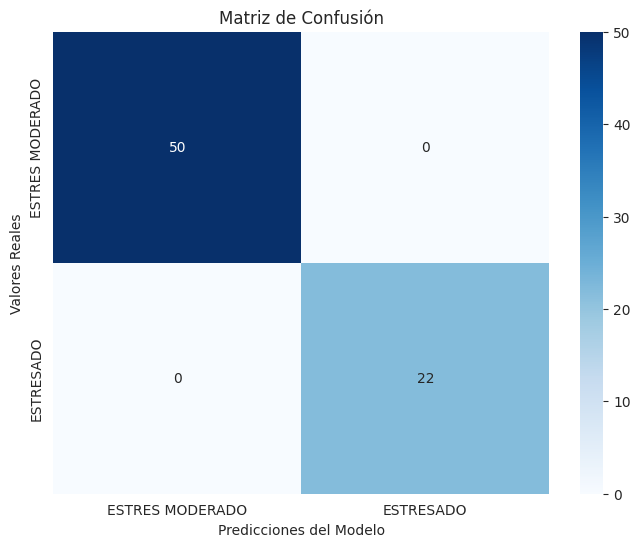


--- Importancia de las Características (Feature Importance) ---
Quality of Sleep           0.380111
Heart Rate                 0.264123
Physical Activity Level    0.089781
Daily Steps                0.059072
Age                        0.055551
Systolic_BP                0.044924
BMI Category_Overweight    0.033903
Occupation_Salesperson     0.018634
Occupation_Teacher         0.013584
Occupation_Engineer        0.011979
dtype: float64


/tmp/ipython-input-3516606610.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index, palette='viridis')


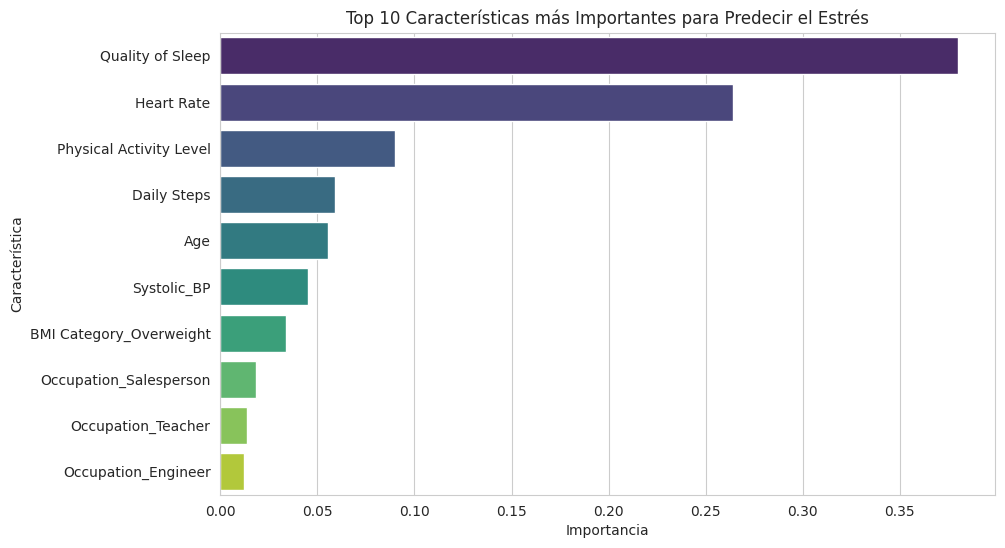

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("=========================================================")
print("  MODELADO DE CLASIFICACIÓN (Random Forest)")
print("=========================================================")

# --- 1. Cargar los Datasets Limpios ---
try:
    # Intente cargar los archivos generados en la fase anterior
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    print("✅ Archivos train.csv y test.csv cargados correctamente.")
except FileNotFoundError:
    print("❌ ERROR: No se encuentran los archivos train.csv o test.csv. Asegúrese de que estén subidos a la sesión de Colab/Jupyter.")
    exit()

# Definir la variable objetivo
TARGET_COL = 'Nivel_Estres_Binario'

# Separar características (X) y objetivo (y)
X_train = df_train.drop(TARGET_COL, axis=1)
y_train = df_train[TARGET_COL]
X_test = df_test.drop(TARGET_COL, axis=1)
y_test = df_test[TARGET_COL]

# --- 2. Entrenamiento del Modelo (Random Forest) ---

# Inicializar el modelo Random Forest
# Se usa un número de árboles (n_estimators) y un estado aleatorio para reproducibilidad
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("\n⚙️ Iniciando entrenamiento del modelo...")
model.fit(X_train, y_train)
print("✅ Entrenamiento completado.")

# --- 3. Predicción y Evaluación ---

# Predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# 3.1. Métricas de Evaluación
accuracy = accuracy_score(y_test, y_pred)
print("\n--- Resultados de la Evaluación ---")
print(f"Precisión (Accuracy) General del Modelo: {accuracy:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# 3.2. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matriz de Confusión')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones del Modelo')
plt.show()

# --- 4. Importancia de las Características ---

# Obtener la importancia de cada característica
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("\n--- Importancia de las Características (Feature Importance) ---")
print(feature_importances.head(10))

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index, palette='viridis')
plt.title('Top 10 Características más Importantes para Predecir el Estrés')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()